# **Machine Learning and Text Classification BBC Texts**

Source: https://www.kaggle.com/datasets/hgultekin/bbcnewsarchive

In [ ]:
!gdown 16Snlvv5JeBpIU58EVQAJ7BVakEMYhbU5

Downloading...
From: https://drive.google.com/uc?id=16Snlvv5JeBpIU58EVQAJ7BVakEMYhbU5
To: /content/bbc-news-data.csv
100% 5.08M/5.08M [00:00<00:00, 45.3MB/s]


In [ ]:
import pandas as pd

In [ ]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import accuracy_score,f1_score
from sklearn.feature_extraction.text import CountVectorizer
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
data = pd.read_csv("/content/bbc-news-data.csv", encoding="utf-8", sep='\t')


In [ ]:
len(data.index)

2225

In [ ]:
data['totalwords'] = data['content'].str.split().str.len()

In [ ]:
data.head()

,category,filename,title,content,totalwords
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,415
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,379
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,258
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,400
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,260


In [ ]:
import plotly.express as px

fig = px.histogram(data, x="category", y="totalwords", histfunc="avg")
fig.write_html("overview_texts_categories.html")
fig.show()

In [ ]:
data["category"]

,category
0,business
1,business
2,business
3,business
4,business
...,...
2220,tech
2221,tech
2222,tech
2223,tech


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data["content"], data["category"], test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [ ]:
y_train.value_counts()

,count
category,
business,324
sport,308
politics,245
entertainment,234
tech,224


In [ ]:
fig4 = px.histogram(y_train, x="category")
fig4.write_html("texts_categories.html")
fig4.show()

In [ ]:
fig2 = px.pie(data, values="totalwords", names='category')
fig2.show()
fig2.write_html("overview_words_category.html")

Encode the categories as values

In [ ]:
le =LabelEncoder()
le.fit(y_train)
print(le.classes_)
train_y=le.transform(y_train)
val_y=le.transform(y_val)
test_y=le.transform(y_test)

['business' 'entertainment' 'politics' 'sport' 'tech']


Turn the text into vectors

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit_transform(X_train)
train_x=vectorizer.transform(X_train)
val_x=vectorizer.transform(X_val)
test_x=vectorizer.transform(X_test)

Turn all datasets into tensors for the model

In [ ]:
# change arrays into tensors
train_x_tensor=torch.tensor(train_x.toarray()).float()
train_y_tensor=torch.tensor(train_y)

val_x_tensor=torch.tensor(val_x.toarray()).float()
val_y_tensor=torch.tensor(val_y)

test_x_tensor=torch.tensor(test_x.toarray()).float()
test_y_tensor=torch.tensor(test_y)

In [ ]:
train_x_tensor=torch.tensor(train_x.toarray()).float()
train_x_tensor.size()

torch.Size([1335, 23699])

Get a first impression with a simple MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
clf = MLPClassifier(random_state=1, hidden_layer_sizes=(300,100), max_iter=300).fit(train_x, train_y)

y_pred_val=clf.predict(val_x)
accuracy_score(val_y, y_pred_val),precision_recall_fscore_support(val_y, y_pred_val)

(0.9685393258426966,
 (array([0.95049505, 0.95714286, 0.95061728, 0.99047619, 0.98863636]),
  array([0.96      , 0.98529412, 0.9625    , 1.        , 0.93548387]),
  array([0.95522388, 0.97101449, 0.95652174, 0.99521531, 0.96132597]),
  array([100,  68,  80, 104,  93])))

Build the model

In [ ]:
class ClassificationNet(nn.Module):

    def __init__(self):
        super(ClassificationNet, self).__init__()
        self.layers = nn.Sequential(
        nn.Linear(23699, 512), #feature number, first layer size
        nn.Hardtanh(),
        nn.Linear(512,5) #we have 5 categories!
        )

    def forward(self, x): #forward pass, input shape(data points, feature number)
        sm = nn.Softmax(dim=1) #activation function
        x = sm(self.layers(x))
        return x

net = ClassificationNet()

In [ ]:
# learning rate
lrt=0.01

# optimizer
optimizer = optim.Adam(net.parameters(), lr=lrt)

# loss/criterion
criterion = nn.CrossEntropyLoss()

# epochs / number of training iterations
epochs = 50

In [ ]:
def evaluation_metrics(predict_y,ground_truth_y):

    accuracy=accuracy_score(ground_truth_y,predict_y)
    f1score=f1_score(ground_truth_y,predict_y,average='macro')

    return (accuracy,f1score)

In [ ]:
import numpy as np

train_err=[]
val_err =[]

for i in range(epochs):
    # step 1. zero the gradients
    optimizer.zero_grad()

    # step 2. compute the output
    output = net(train_x_tensor)

    # step 3. compute the loss
    loss = criterion(output, train_y_tensor)

    # step 4. use the loss to produce the gradients
    loss.backward()

    # step 5. use the optimizer to update the weights
    optimizer.step()

    with torch.no_grad():

        # compute output
        output_val= net(val_x_tensor)

        # compute loss
        loss_val = criterion(output_val, val_y_tensor)

        # compute prediction
        predict_y= [np.argmax(i.detach().numpy()) for i in output_val]

        # "evaluation_metrics" function for accuracy and f1 score
        accuracy,f1score=evaluation_metrics(predict_y,val_y_tensor)

        train_err.append(loss.item())
        val_err.append(loss_val.item())

        print('Epoch %d/%d - Loss_train: %.3f   loss_val: %.3f   accuracy_val: %.3f f1score_val: %.3f   '% \
              (i + 1, epochs,loss.item(),loss_val.item(),accuracy,f1score))

Epoch 1/50 - Loss_train: 1.610   loss_val: 1.122   accuracy_val: 0.798 f1score_val: 0.726   
Epoch 2/50 - Loss_train: 1.058   loss_val: 1.047   accuracy_val: 0.856 f1score_val: 0.849   
Epoch 3/50 - Loss_train: 0.953   loss_val: 0.951   accuracy_val: 0.960 f1score_val: 0.959   
Epoch 4/50 - Loss_train: 0.911   loss_val: 0.966   accuracy_val: 0.942 f1score_val: 0.937   
Epoch 5/50 - Loss_train: 0.913   loss_val: 0.990   accuracy_val: 0.921 f1score_val: 0.916   
Epoch 6/50 - Loss_train: 0.913   loss_val: 0.988   accuracy_val: 0.919 f1score_val: 0.915   
Epoch 7/50 - Loss_train: 0.909   loss_val: 0.982   accuracy_val: 0.926 f1score_val: 0.922   
Epoch 8/50 - Loss_train: 0.908   loss_val: 0.976   accuracy_val: 0.928 f1score_val: 0.925   
Epoch 9/50 - Loss_train: 0.907   loss_val: 0.970   accuracy_val: 0.930 f1score_val: 0.927   
Epoch 10/50 - Loss_train: 0.907   loss_val: 0.965   accuracy_val: 0.939 f1score_val: 0.936   
Epoch 11/50 - Loss_train: 0.906   loss_val: 0.961   accuracy_val: 0.9

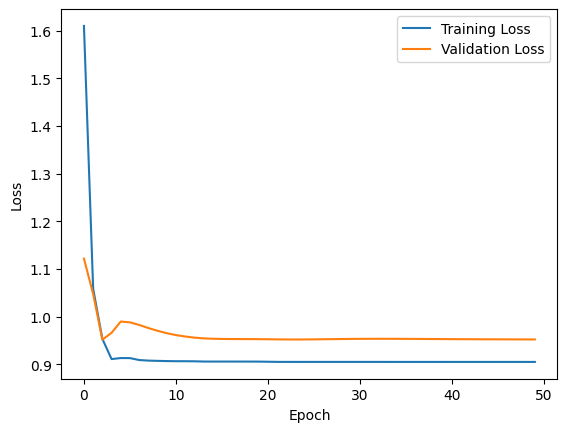

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_err, label='Training Loss')
plt.plot(val_err, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
    # compute the output
    output_test= net(test_x_tensor)

    # compute the prediction
    predict_test_y= [np.argmax(i.detach().numpy()) for i in output_test]

    # Use the "evaluation_metrics" function to find accuracy and f1 score
    accuracy,f1score=evaluation_metrics(predict_test_y,test_y_tensor)
    print('Accuracy_test: %.3f f1score_val: %.3f   '% (accuracy,f1score))

Accuracy_test: 0.962 f1score_val: 0.962   


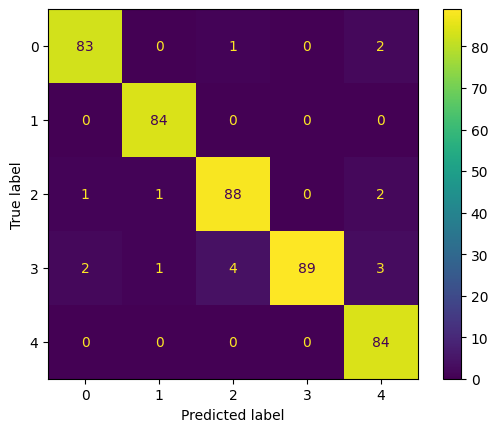

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_y_tensor, predict_test_y, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()